# Physics-Informed Unsupervised Representation Learning for Pixel Observations of Dynamical Systems

Most machine learning models today still lack a basic understanding of the environment around them, as they do not have any encoded physical knowledge. This prevents them from learning accurate representations of observed dynamical systems, especially in the context of visual observations without any domain-specific knowledge of the system. In a comprehensive literature review, this thesis first clarifies the state of the art in this young and dynamic field of research of physics-informed unsupervised representation learning. On this basis, a general model with encoded Lagrangian and Hamiltonian principles is constructed to discover the underlying governing equations of a dynamical system purely from image observations. The models are tested for their ability to encode and predict meaningful parameters and generate future images without domain-specific knowledge. A general framework consisting of an autoencoder and a dynamic network is proposed, where different types and versions are tested to discover the best autoencoder type as well as the differences that arise between Lagrangian, Hamiltonian and no priors. The results underline the advantages of models with encoded physical principles, whereby the Hamiltonian model proves to be the best. The analysis revealed the importance of symplectic integrators, the training method and other attributes, which leaves much room for further research.

# 0. Imports

In [1]:
# load required packages
import torch
from os import path
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Image
import cv2 as cv
import numpy as np
import math
import tqdm
import matplotlib.image as mpimg

# import from model
from utils import figures
from utils.helper import convert_data, read_config
from utils.file_manager import load_model, pickle_save, pickle_load
from data import get_dataset

# save paths
THIS_DIR = path.dirname(path.abspath("evaluate.ipynb"))
DATA_DIR = path.join(THIS_DIR, "saved_data")
MODEL_DIR = path.join(THIS_DIR, "saved_models")
FIG_DIR = path.join(THIS_DIR, "figures")
DATA_CONFIG_DIR = path.abspath(path.join(THIS_DIR, 'config/data_config.yaml'))
TRAIN_CONFIG_DIR = path.abspath(path.join(THIS_DIR, 'config/train_config.yaml'))

# 1. Create/Load data

Successfully loaded saved_data from path /Users/jantiegges/Google Drive/Bachelorarbeit/BA/saved_data/pendulum_1000_100_64_3_1.pkl

Example of training data


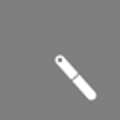

In [2]:
# load data config file
data_config = read_config(DATA_CONFIG_DIR)
train_config = read_config(TRAIN_CONFIG_DIR)

# properties of dataset (to specify in data_conifg.yaml)
system = data_config['system']
ep = data_config['episodes']
ts = data_config['timesteps']
im_size = data_config['im_size']
seq_len = data_config['seq_len']
channels = data_config['channels']
latent_dim = data_config['latent_dim']
batch_size = train_config['batch_size']

# load dataset
# if dataset doesn't exist yet, it will be constructed from the OpenAI Gym environment
filename = f"{system}_{ep}_{ts}_{im_size}_{seq_len}_{channels}"
data, data_config = get_dataset(data_config, system, DATA_DIR, filename, seed=32)

# convert data to fit input shape for PixelDDN
trainset, testset = convert_data(data)

trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False)

# takes frames of first episode
frames = data['train_data'][0,:,0,:,:,0]

# creates and saves gif
path = "./figures"
gifname = figures.make_gif(frames, path, filename, duration=1e-1, pixels=[120, 120])

print("\nExample of training data")
Image(filename=gifname, width=200)

# 2. Load models 
 
### Model Overview

|	|   Multilayer-Perceptron   |   Lagrangian Neural Network   |   Hamiltonian Neural Network   | 
| ------------- |:------------:| :------------:| :------------:|
| Autoencoder | MLP_LAE | LNN_LAE | HNN_LAE |
| Variational Autoencoder | MLP_VAE| LNN_VAE | HNN_VAE |
| Convolutional Autoencoder | MLP_CAE | LNN_CAE | HNN_CAE |
| Convolutional Variational Autoencoder | MLP_CVAE | LNN_CVAE | HNN_CVAE |

In [3]:
# choose models to compare (add as many as you like to the list)
model_names = ["HNN_CVAE",
               "LNN_CVAE",
               "MLP_CVAE"]

In [4]:
# load saved models
models = [None] * len(model_names)

for i, model_name in enumerate(model_names):
    path = f"{MODEL_DIR}/{model_name}"
    models[i] = load_model(model_name, data_config, path)

# 3. Training/Testing

## 3.1 Course of Training

Below one can see a comparison of the different training behaviour of the models.

Average test error of model HNN_CVAE :  0.000772
Average test error of model LNN_CVAE :  0.00202
Average test error of model MLP_CVAE :  0.002566


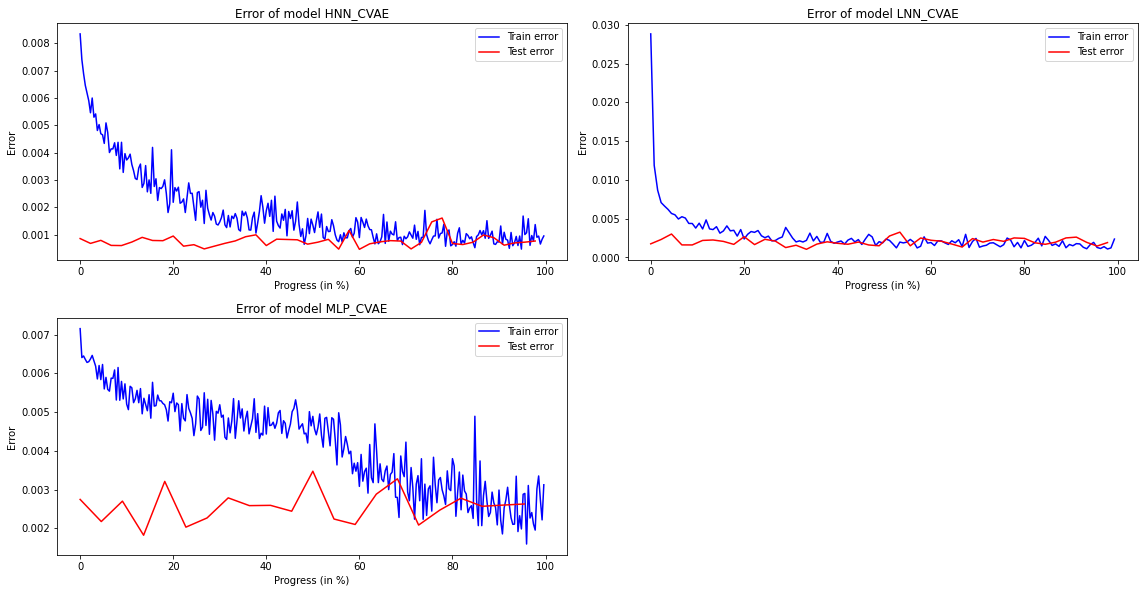

In [5]:
train_error = [None] * len(models)
test_error = [None] * len(models)
train_axis = [None] * len(models)
test_axis = [None] * len(models)

# load train and test data
for i, model_name in enumerate(model_names):
    path = f"{MODEL_DIR}/{model_name}/train_log"
    train_log = pickle_load(path)
    path = f"{MODEL_DIR}/{model_name}/test_log"
    test_log = pickle_load(path)
    
    train_error[i] = np.zeros(len(train_log))
    test_error[i] = np.zeros(len(test_log))
    train_axis[i] = np.zeros(len(train_log))
    test_axis[i] = np.zeros(len(test_log))
    
    for j in range(len(train_log)):
        train_error[i][j] = train_log[j]['Reconstruction Loss'].detach().numpy()
    for j in range(len(test_log)):
        test_error[i][j] = test_log[j]['Reconstruction Loss'].detach().numpy()   
    for j in range(len(train_log)):
        train_axis[i][j] = j/len(train_log) * 100
    for j in range(len(test_log)):
        test_axis[i][j] = j/len(test_log) * 100        
    
# plot error    
fig = plt.figure(figsize=(16, 12))
ax = []

for i, tr_loss in enumerate(train_error):
    ax.append(fig.add_subplot(len(models),2,i+1))
    plt.plot(train_axis[i], train_error[i],'-', color='blue', label="Train error")
    plt.plot(test_axis[i], test_error[i],'-', color='red', label="Test error")
    ax[i].set_xlabel("Progress (in %)")
    ax[i].set_ylabel("Error")
    plt.title(f"Error of model {model_names[i]}")
    plt.legend()
    print("Average test error of model", model_names[i], ": ", np.round(np.average(test_error[i]), 6))

plt.tight_layout() ; plt.show()

## 3.2 Model Accuracy

The following table shall provide an overview of the average test error of all models to get a sense of their capabilities.


| MLP model | error |  LNN model  | error | HNN model  | error | 
| ------------- |:------------:| :------------:| :------------:| :------------:| :------------:|
| MLP_LAE  | 6.741-3 | LNN_LAE |  3.928e-3 |HNN_LAE | 6.692e-3 |
| MLP_VAE  | 6.507-3| LNN_VAE |  2.910-3 |HNN_VAE | 2.530-3 |
| MLP_CAE  | 5.457-3 | LNN_CAE |  2.159-3 |HNN_CAE | 1.066-3 |
| MLP_CVAE | 2.566-3 | LNN_CVAE |  2.020-3 |HNN_CVAE | 0.772-3 |

## 3.3 Training Duration

The following table shall provide an overview of the general training time for the models. Despite the fact that the absolut time doesn't have that much significance on its own, the relative comparison between the times enables an idea of how elaborate their training is.

Training Epochs: 3

Batch Size: 16


| MLP model | time (in h) |  LNN model  | time (in h) | HNN model  | time (in h) | 
| ------------- |:------------:| :------------:| :------------:| :------------:| :------------:|
| MLP_LAE  | 0:20 | LNN_LAE |  2:25 |HNN_LAE | 0:26 |
| MLP_VAE  | -| LNN_VAE |  - |HNN_VAE | - |
| MLP_CAE  | 5:14 | LNN_CAE |  - |HNN_CAE | - |
| MLP_CVAE | - | LNN_CVAE |  - |HNN_CVAE | - |

# 4. Autoencoder

## 4.1 Input Sequences

Each input sequence consists of only three consecutive images that are linked together.

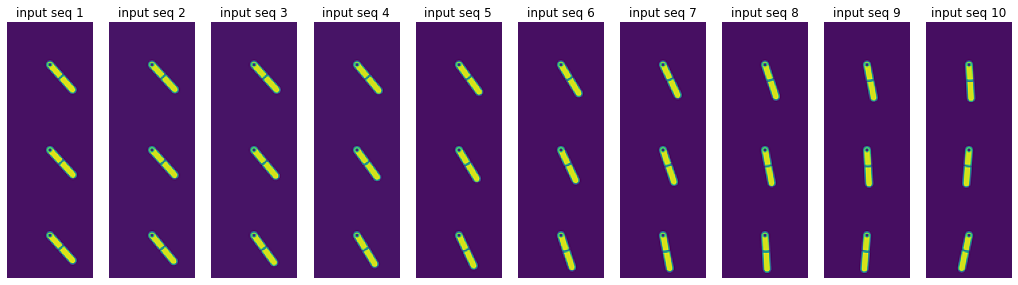

In [6]:
# choose random input images
input_img = data['train_data'][0,:10,:seq_len,...]

fig = plt.figure(figsize=(18,5))
ax = []
input_len = input_img.shape[0]
idx = 1

# plot input images
for i in range(input_len):
    ax.append(fig.add_subplot(1,input_len,idx))
    ax[-1].set_title(f"input seq {i+1}")
    img = input_img[i,:seq_len,...].reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1

## 4.2 Reconstruction of Autoencoder from input images

This figure shows the reconstruction of the last input image from the input sequence. The first row shows the target images while each other row represents one model.

Row 1: Target images
Row 2: HNN_CVAE
Row 3: LNN_CVAE
Row 4: MLP_CVAE


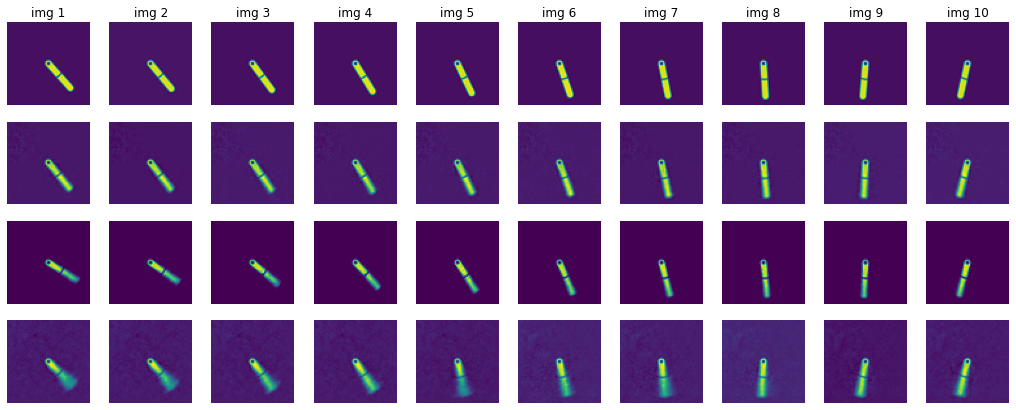

In [7]:
# convert numpy to tensor
batch = torch.tensor(input_img)
b, s, h, w, c = batch.size()


fig = plt.figure(figsize=(18,7))
ax = []
input_len = batch.shape[0]
idx = 1

# plot target images
for i in range(input_len):
    ax.append(fig.add_subplot(len(models)+1,input_len,idx))
    ax[-1].set_title(f"img {i+1}")
    img = batch[i,-1,...].numpy().reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1
    
print(f"Row 1: Target images")

# plot output images
for i, model in enumerate(models):
    if model.ae_params['convolutional']:
        this_batch = batch.reshape(b, s * c, h, w)
    else:
        this_batch = batch.reshape(b, s * c * h * w)
        
    # get reconstruction
    x_hat = model.ae(this_batch)
    
    for j in range(input_len):
        ax.append(fig.add_subplot(len(models)+1,input_len,idx))
        img = x_hat[j,...].detach().numpy().reshape(-1, im_size)
        plt.axis('off')
        plt.imshow(img)
        #ax[-1].set_ylabel("Hallo")
        idx += 1
        
    print(f"Row {i+2}: {model_names[i]}")

## 4.3 Reconstruction of Autoencoder from position parameter

This figure shows the reconstruction of images from the original position parameter (this doesn't really have a representive meaning, but is rather interesting to set)

Row 1: Target images
Row 2: HNN_CVAE
Row 3: LNN_CVAE
Row 4: MLP_CVAE


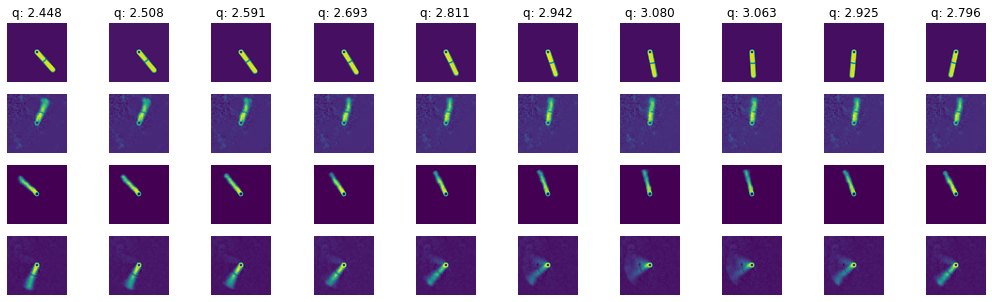

In [8]:
coords_in = data['train_meta_data']['gcoords_in'][0,:10]
    
q = coords_in[:, :int(latent_dim / 2)]

# optional position parameters for distinctive positions
#q = np.array([[0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi, 5*math.pi/4, 3*math.pi/2, 7*math.pi/4, 2*math.pi, -math.pi],])
#q.resize((q.shape[1],1))

fig = plt.figure(figsize=(18,5))
ax = []
input_len = batch.shape[0]
idx = 1

# plot target images
for i in range(input_len):
    ax.append(fig.add_subplot(len(models)+1,input_len,idx))
    ax[-1].set_title(f"q: {q[i][0]:.3f}")
    img = batch[i,-1,...].numpy().reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1
    
print(f"Row 1: Target images")

# plot output images
for i, model in enumerate(models):
    
    # get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
    if 'LNN' in model_names[i]:
        coords_in = data['train_meta_data']['gcoords_in'][0,:10]
    elif 'HNN' in model_names[i]:
        coords_in = data['train_meta_data']['ccoords_in'][0,:10]
    else:
        # choose canonical or generalized coordinates for MLP network?
        coords_in = data['train_meta_data']['ccoords_in'][0,:10]
        
    q = coords_in[:, :int(latent_dim / 2)]
    q_tens = torch.tensor(q)
    
    # get reconstruction
    x_hat = model.ae.decode(q_tens.float())
    
    for j in range(input_len):
        ax.append(fig.add_subplot(len(models)+1,input_len,idx))
        img = x_hat[j,...].detach().numpy().reshape(-1, im_size)
        plt.axis('off')
        plt.imshow(img)
        #ax[-1].set_ylabel("Hallo")
        idx += 1
        
    print(f"Row {i+2}: {model_names[i]}")

# 5. Latent Space

## 5.1 Encoded Dynamic Parameter

This figure shows the latent representation of the input images for a single model.

### Encoded Parameter of first model

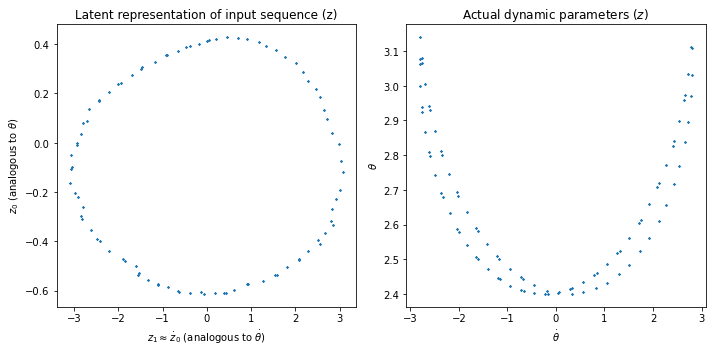

In [9]:
this_model = models[0]
model_name = model_names[0]

x = data['train_data'][0,:,:seq_len,...]
# convert numpy to tensor
batch = torch.tensor(x)

# concat along channel dimension
b, s, h, w, c = batch.size()

# if convolutional
if this_model.ae_params['convolutional']:
    batch = batch.reshape(b, s * c, h, w)
else:
    batch = batch.reshape(b, s * c * h * w)
    
if this_model.ae_params['variational']:
    mu, log = this_model.ae.encode(batch)
    z_latent = this_model.ae.reparameterize(mu, log).detach().numpy()
else:
    z_latent = this_model.ae.encode(batch).detach().numpy()

# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'LNN' in model_name:
    z_actual = data['train_meta_data']['gcoords_in'][0,:]
elif 'HNN' in model_name:
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
else:
    # choose canonical or generalized coordinates for MLP network?
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
    
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
plt.plot(z_latent[:,1], z_latent[:,0],'*', markersize=2)
ax1.set_xlabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
ax1.set_ylabel("$z_0$ (analogous to $\\theta$)")
plt.title("Latent representation of input sequence (z)")

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(z_actual[:,1], z_actual[:,0], '*', markersize=2)
ax2.set_xlabel("$\dot \\theta$")
ax2.set_ylabel("$\\theta$")
plt.title("Actual dynamic parameters ($z$)")

plt.tight_layout() ; plt.show()

### Model comparison on encoded parameters

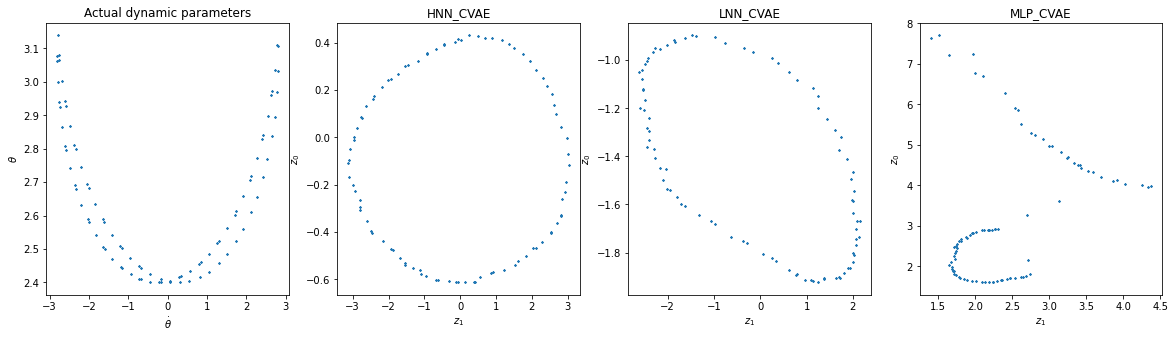

In [10]:
# convert numpy to tensor
x = data['train_data'][0,:,:seq_len,...]
batch = torch.tensor(x)
b, s, h, w, c = batch.size()


fig = plt.figure(figsize=(20,5))
ax = []
input_len = batch.shape[0]
idx = 1

# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'LNN' in model_names[0]:
    z_actual = data['train_meta_data']['gcoords_in'][0,:]
elif 'HNN' in model_names[0]:
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
else:
    # choose canonical or generalized coordinates for MLP network?
    z_actual = data['train_meta_data']['ccoords_in'][0,:]

# plot actual representation
ax.append(fig.add_subplot(1,len(models)+1,1))
plt.plot(z_actual[:,1], z_actual[:,0], '*', markersize=2)
ax[-1].set_xlabel("$\dot \\theta$")
ax[0].set_ylabel("$\\theta$")
ax[-1].set_title("Actual dynamic parameters")

# plot output images
for i, model in enumerate(models):
    if model.ae_params['convolutional']:
        this_batch = batch.reshape(b, s * c, h, w)
    else:
        this_batch = batch.reshape(b, s * c * h * w)
        
    # get latent representation
    if model.ae_params['variational']:
        mu, log = model.ae.encode(this_batch)
        z_latent = model.ae.reparameterize(mu, log).detach().numpy()
    else:
        z_latent = model.ae.encode(this_batch).detach().numpy()
    
    # plot latent representation
    ax.append(fig.add_subplot(1,len(models)+1,i+2))
    plt.plot(z_latent[:,1], z_latent[:,0],'*', markersize=2)
    ax[-1].set_xlabel("$z_1$")
    ax[-1].set_ylabel("$z_0$")
    ax[-1].set_title(f"{model_names[i]}")

### Encoded Parameter of first model over time

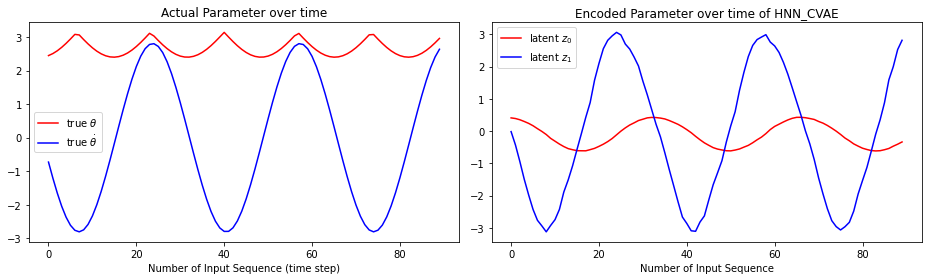

In [11]:
this_model = models[0]
model_name = model_names[0]

x = data['train_data'][0,:,:seq_len,...]
# convert numpy to tensor
batch = torch.tensor(x)

# concat along channel dimension
b, s, h, w, c = batch.size()

# if convolutional
if this_model.ae_params['convolutional']:
    batch = batch.reshape(b, s * c, h, w)
else:
    batch = batch.reshape(b, s * c * h * w)
    
if this_model.ae_params['variational']:
    mu, log = this_model.ae.encode(batch)
    z_latent = this_model.ae.reparameterize(mu, log).detach().numpy()
else:
    z_latent = this_model.ae.encode(batch).detach().numpy()

# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'LNN' in model_name:
    z_actual = data['train_meta_data']['gcoords_in'][0,:]
elif 'HNN' in model_name:
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
else:
    # choose canonical or generalized coordinates for MLP network?
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
    
fig = plt.figure(figsize=[13,4])
plt.subplot(1,2,1)
plt.plot(z_actual[:,0], "r-", label='true $\\theta$')
plt.plot(z_actual[:,1], "b-", label='true $\dot \\theta$')
plt.xlabel("Number of Input Sequence (time step)")
plt.title("Actual Parameter over time")
plt.legend()

plt.subplot(1,2,2)
plt.plot(z_latent[:,0], "r-", label='latent $z_0$') 
plt.plot(z_latent[:,1], "b-", label='latent $z_1$')
plt.xlabel("Number of Input Sequence")
plt.title(f"Encoded Parameter over time of {model_names[0]}")
plt.legend()

plt.tight_layout() ; plt.show()

### Model comparison of encoded Parameter over time

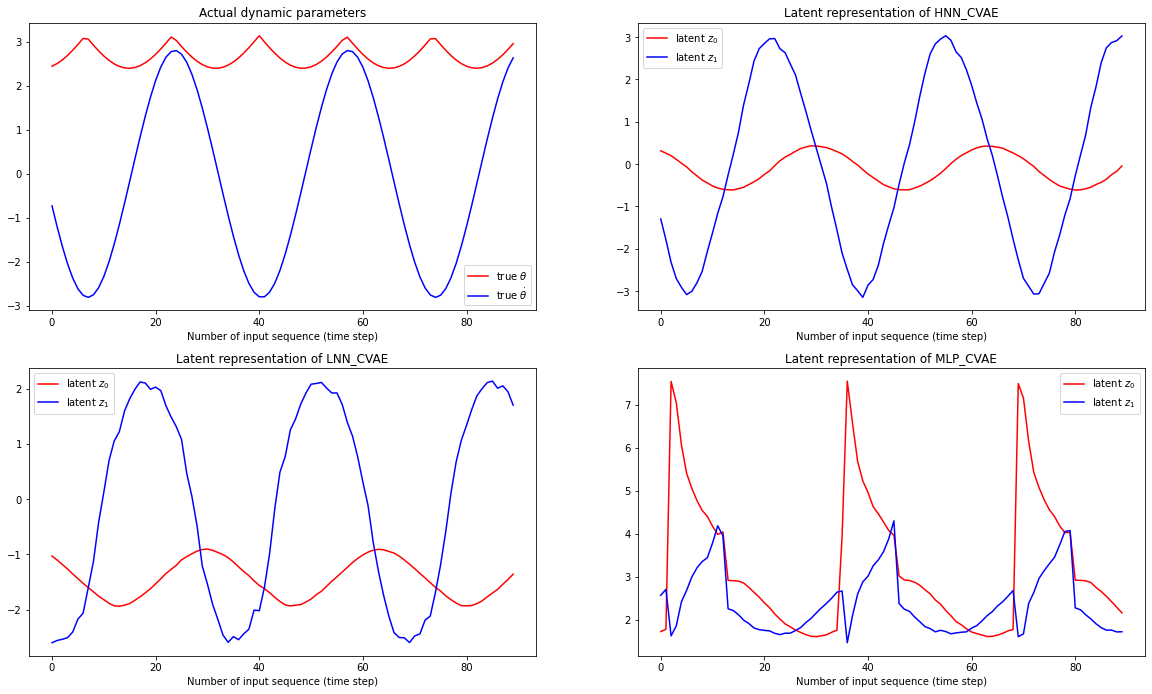

In [12]:
# convert numpy to tensor
x = data['test_data'][0,:,:seq_len,...]
batch = torch.tensor(x)
b, s, h, w, c = batch.size()


fig = plt.figure(figsize=(20,18))
ax = []
input_len = batch.shape[0]
idx = 1

# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'LNN' in model_names[0]:
    z_actual = data['train_meta_data']['gcoords_in'][0,:]
elif 'HNN' in model_names[0]:
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
else:
    # choose canonical or generalized coordinates for MLP network?
    z_actual = data['train_meta_data']['ccoords_in'][0,:]

# plot actual representation
ax.append(fig.add_subplot(len(models),2,idx))
plt.plot(z_actual[:,0], "r-", label='true $\\theta$')
plt.plot(z_actual[:,1], "b-", label='true $\dot \\theta$')
#plt.plot(z_actual[:,1], "b-", label='true $p$')
ax[-1].set_title("Actual dynamic parameters")
ax[-1].set_xlabel("Number of input sequence (time step)")
plt.legend()
idx += 1

# plot output images
for i, model in enumerate(models):
    if model.ae_params['convolutional']:
        this_batch = batch.reshape(b, s * c, h, w)
    else:
        this_batch = batch.reshape(b, s * c * h * w)
        
    # get latent representation
    if model.ae_params['variational']:
        mu, log = model.ae.encode(this_batch)
        z_latent = model.ae.reparameterize(mu, log).detach().numpy()
    else:
        z_latent = model.ae.encode(this_batch).detach().numpy()
    
    # plot latent representation
    ax.append(fig.add_subplot(len(models),2,idx))
    plt.plot(z_latent[:,0], "r-", label='latent $z_0$') 
    plt.plot(z_latent[:,1], "b-", label='latent $z_1$')
    ax[-1].set_title(f"Latent representation of {model_names[i]}")
    ax[-1].set_xlabel("Number of input sequence (time step)")
    plt.legend()
    idx += 1
    
#ax[6].set_xlabel("Number of Input Sequence")
#ax[7].set_xlabel("Number of Input Sequence")

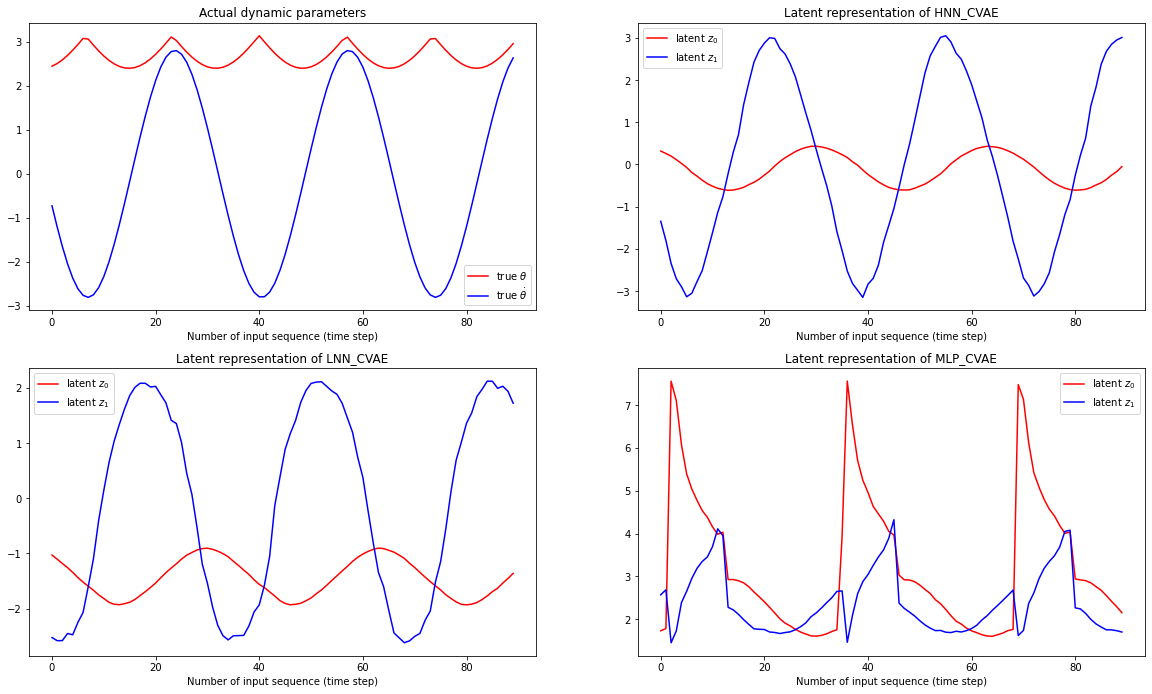

In [13]:
# convert numpy to tensor
x = data['test_data'][0,:,:seq_len,...]
batch = torch.tensor(x)
b, s, h, w, c = batch.size()


fig = plt.figure(figsize=(20,18))
ax = []
input_len = batch.shape[0]
idx = 1

# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'LNN' in model_names[0]:
    z_actual = data['train_meta_data']['gcoords_in'][0,:]
elif 'HNN' in model_names[0]:
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
else:
    # choose canonical or generalized coordinates for MLP network?
    z_actual = data['train_meta_data']['ccoords_in'][0,:]

# plot actual representation
ax.append(fig.add_subplot(len(models),2,idx))
plt.plot(z_actual[:,0], "r-", label='true $\\theta$')
plt.plot(z_actual[:,1], "b-", label='true $\dot \\theta$')
#plt.plot(z_actual[:,1], "b-", label='true $p$')
ax[-1].set_title("Actual dynamic parameters")
ax[-1].set_xlabel("Number of input sequence (time step)")
plt.legend()
idx += 1

# plot output images
for i, model in enumerate(models):
    if model.ae_params['convolutional']:
        this_batch = batch.reshape(b, s * c, h, w)
    else:
        this_batch = batch.reshape(b, s * c * h * w)
        
    # get latent representation
    if model.ae_params['variational']:
        mu, log = model.ae.encode(this_batch)
        z_latent = model.ae.reparameterize(mu, log).detach().numpy()
    else:
        z_latent = model.ae.encode(this_batch).detach().numpy()
    
    # plot latent representation
    ax.append(fig.add_subplot(len(models),2,idx))
    plt.plot(z_latent[:,0], "r-", label='latent $z_0$') 
    plt.plot(z_latent[:,1], "b-", label='latent $z_1$')
    ax[-1].set_title(f"Latent representation of {model_names[i]}")
    ax[-1].set_xlabel("Number of input sequence (time step)")
    plt.legend()
    idx += 1
    
#ax[6].set_xlabel("Number of Input Sequence")
#ax[7].set_xlabel("Number of Input Sequence")

## 5.2 Predicted Dynamic Parameter

In [14]:
# number of timesteps to predict
pred_steps = 89

batch_bar = tqdm.tqdm(testloader, disable=True)

# get prediction for one batch
for i, batch in enumerate(testloader):
    input = batch[:, :seq_len, ...]
    target = batch[:, (seq_len - 1):, ...]
    break
    
pred = [None] * len(models)

for i, model in enumerate(models):
    pred[i] = model(input, pred_steps, model.ae_params['variational'], model.ae_params['convolutional'])

In [15]:
# save prediction
pred_img = [None] * len(models)
pred_z0 = [None] * len(models)
pred_z1 = [None] * len(models)
pred_z2 = [None] * len(models)
pred_energies = [None] * len(models)

for i, model in enumerate(models):
    pred_img[i] = pred[i].reconstruction.detach().numpy()

    pred_z0[i] = np.zeros(pred_steps+1)
    pred_z1[i] = np.zeros(pred_steps+1)
    pred_z2[i] = np.zeros(pred_steps+1)
    pred_energies[i] = np.zeros(pred_steps+1)

    for j in range(pred_steps+1):
        if 'LNN' in model_names[i]:
            pred_z0[i][j] = pred[i].q[j][0].detach().numpy()
            pred_z1[i][j] = pred[i].qdot[j][0].detach().numpy()
            pred_z2[i][j] = pred[i].qddot[j][0].detach().numpy()
            pred_energies[i][j] = pred[i].energies[j][0]
        # hamiltonian
        elif 'HNN' in model_names[i]:
            pred_z0[i][j] = pred[i].q[j][0].detach().numpy()
            pred_z1[i][j] = pred[i].p[j][0].detach().numpy()
            pred_energies[i][j] = pred[i].energies[j][0]
        else:
            pred_z0[i][j] = pred[i].q[j][0].detach().numpy()
            pred_z1[i][j] = pred[i].p[j][0].detach().numpy()

### Predicted parameter of first model

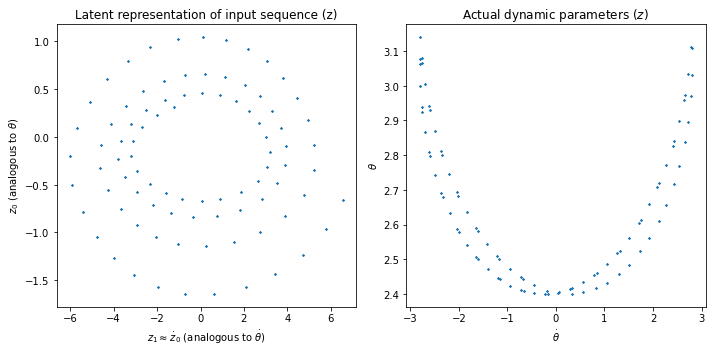

In [16]:
# plot actual dynamic parameters vs latent representation
fig = plt.figure(figsize=(10, 5), facecolor='white')

ax1 = fig.add_subplot(1, 2, 1)
plt.plot(pred_z1[0][:], pred_z0[0][:], '*', markersize=2)
ax1.set_xlabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
ax1.set_ylabel("$z_0$ (analogous to $\\theta$)")
plt.title("Latent representation of input sequence (z)")

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(z_actual[:,1], z_actual[:,0], '*', markersize=2)
ax2.set_xlabel("$\dot \\theta$")
ax2.set_ylabel("$\\theta$")
plt.title("Actual dynamic parameters ($z$)")

plt.tight_layout() ; plt.show()

### Model Comparison of predicted parameter

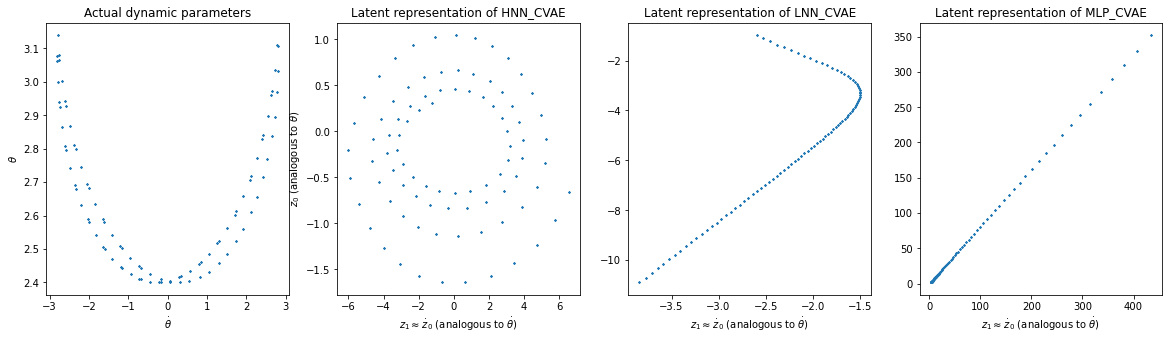

In [17]:
fig = plt.figure(figsize=(20,5))
ax = []
input_len = batch.shape[0]
idx = 1

# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'LNN' in model_names[0]:
    z_actual = data['train_meta_data']['gcoords_in'][0,:]
elif 'HNN' in model_names[0]:
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
else:
    # choose canonical or generalized coordinates for MLP network?
    z_actual = data['train_meta_data']['ccoords_in'][0,:]

# plot actual representation
ax.append(fig.add_subplot(1,len(models)+1,1))
plt.plot(z_actual[:,1], z_actual[:,0], '*', markersize=2)
ax[-1].set_xlabel("$\dot \\theta$")
ax[-1].set_ylabel("$\\theta$")
ax[-1].set_title("Actual dynamic parameters")

# plot output images
for i, model in enumerate(models):
            
    # plot latent representation
    ax.append(fig.add_subplot(1,len(models)+1,i+2))
    plt.plot(pred_z1[i][:], pred_z0[i][:],'*', markersize=2)
    ax[-1].set_xlabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
    ax[1].set_ylabel("$z_0$ (analogous to $\\theta$)")
    ax[-1].set_title(f"Latent representation of {model_names[i]}")

### Predicted Parameter of first model over time

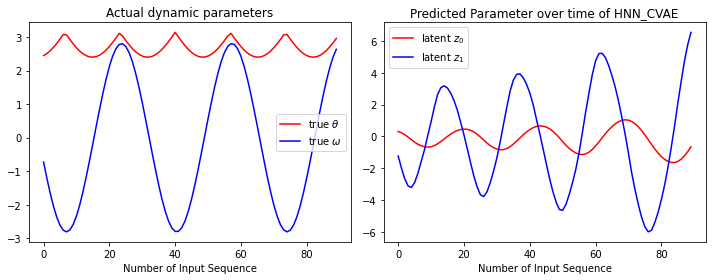

In [18]:
fig = plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(z_actual[:,0], "r-", label='true $\\theta$')
plt.plot(z_actual[:,1], "b-", label='true $\omega$')
plt.xlabel("Number of Input Sequence")
plt.title("Actual dynamic parameters")
plt.legend()

plt.subplot(1,2,2)
plt.plot(pred_z0[0][:], "r-", label='latent $z_0$') 
plt.plot(pred_z1[0][:], "b-", label='latent $z_1$')
plt.xlabel("Number of Input Sequence")
plt.title(f"Predicted Parameter over time of {model_names[0]}")
plt.legend()

plt.tight_layout() ; plt.show()

### Model Comparison of predicted parameter

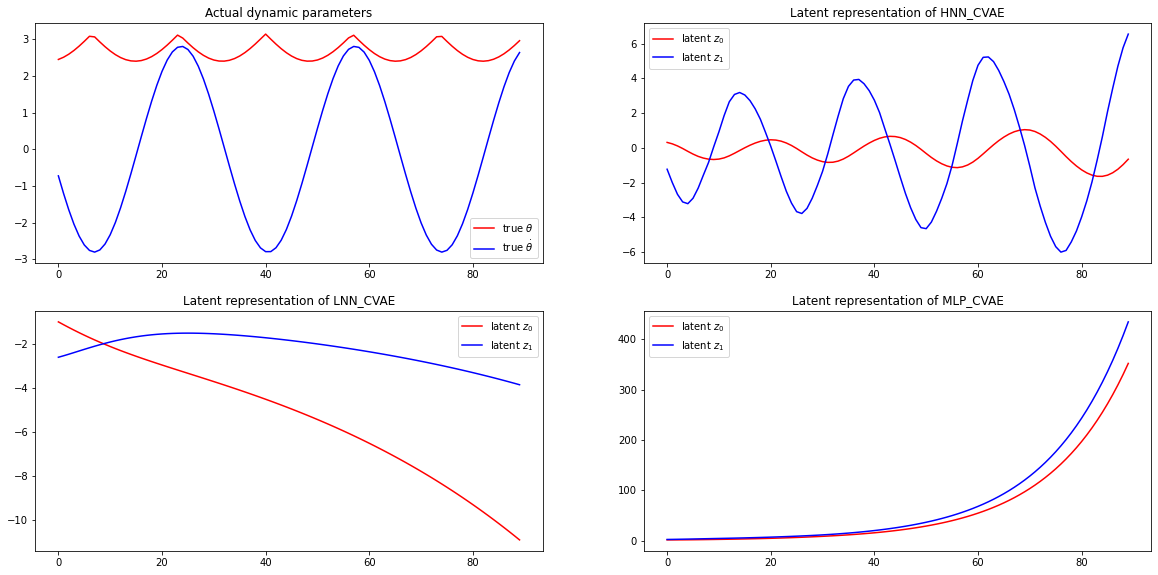

In [19]:
fig = plt.figure(figsize=(20,15))
ax = []
input_len = batch.shape[0]
idx = 1

# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'LNN' in model_names[0]:
    z_actual = data['train_meta_data']['gcoords_in'][0,:]
elif 'HNN' in model_names[0]:
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
else:
    # choose canonical or generalized coordinates for MLP network?
    z_actual = data['train_meta_data']['ccoords_in'][0,:]

# plot actual representation
ax.append(fig.add_subplot(len(models),2,idx))
plt.plot(z_actual[:,0], "r-", label='true $\\theta$')
plt.plot(z_actual[:,1], "b-", label='true $\dot \\theta$')
ax[-1].set_title("Actual dynamic parameters")
plt.legend()
idx += 1

# plot output images
for i, model in enumerate(models):    
        
    # plot latent representation
    ax.append(fig.add_subplot(len(models),2,idx))
    plt.plot(pred_z0[i][:], "r-", label='latent $z_0$') 
    plt.plot(pred_z1[i][:], "b-", label='latent $z_1$')
    ax[-1].set_title(f"Latent representation of {model_names[i]}")
    plt.legend()
    idx += 1

## 5.3 Actual vs Encoded vs Predicted Parameter

### Comparison for first model

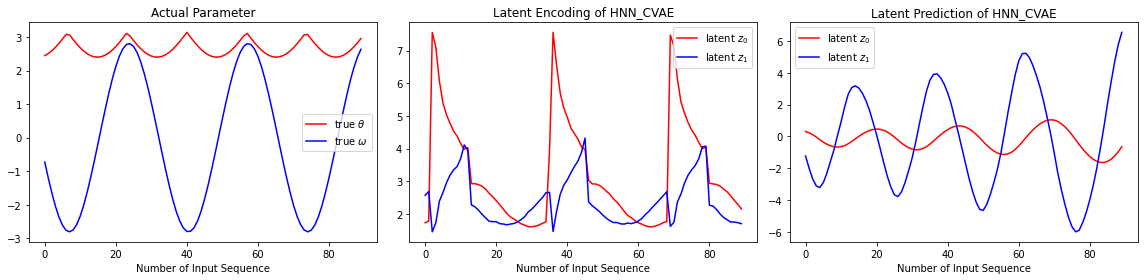

In [20]:
fig = plt.figure(figsize=[16,4])
plt.subplot(1,3,1)
plt.plot(z_actual[:,0], "r-", label='true $\\theta$')
plt.plot(z_actual[:,1], "b-", label='true $\omega$')
plt.xlabel("Number of Input Sequence")
plt.title("Actual Parameter")
plt.legend()

plt.subplot(1,3,2)
plt.plot(z_latent[:,0], "r-", label='latent $z_0$') 
plt.plot(z_latent[:,1], "b-", label='latent $z_1$')
plt.xlabel("Number of Input Sequence")
plt.title(f"Latent Encoding of {model_names[0]}")
plt.legend()

plt.subplot(1,3,3)
plt.plot(pred_z0[0][:], "r-", label='latent $z_0$') 
plt.plot(pred_z1[0][:], "b-", label='latent $z_1$')
plt.xlabel("Number of Input Sequence")
plt.title(f"Latent Prediction of {model_names[0]}")
plt.legend()

plt.tight_layout() ; plt.show()

### Comparison between different models

Text(0, 0.5, '$\\theta$')

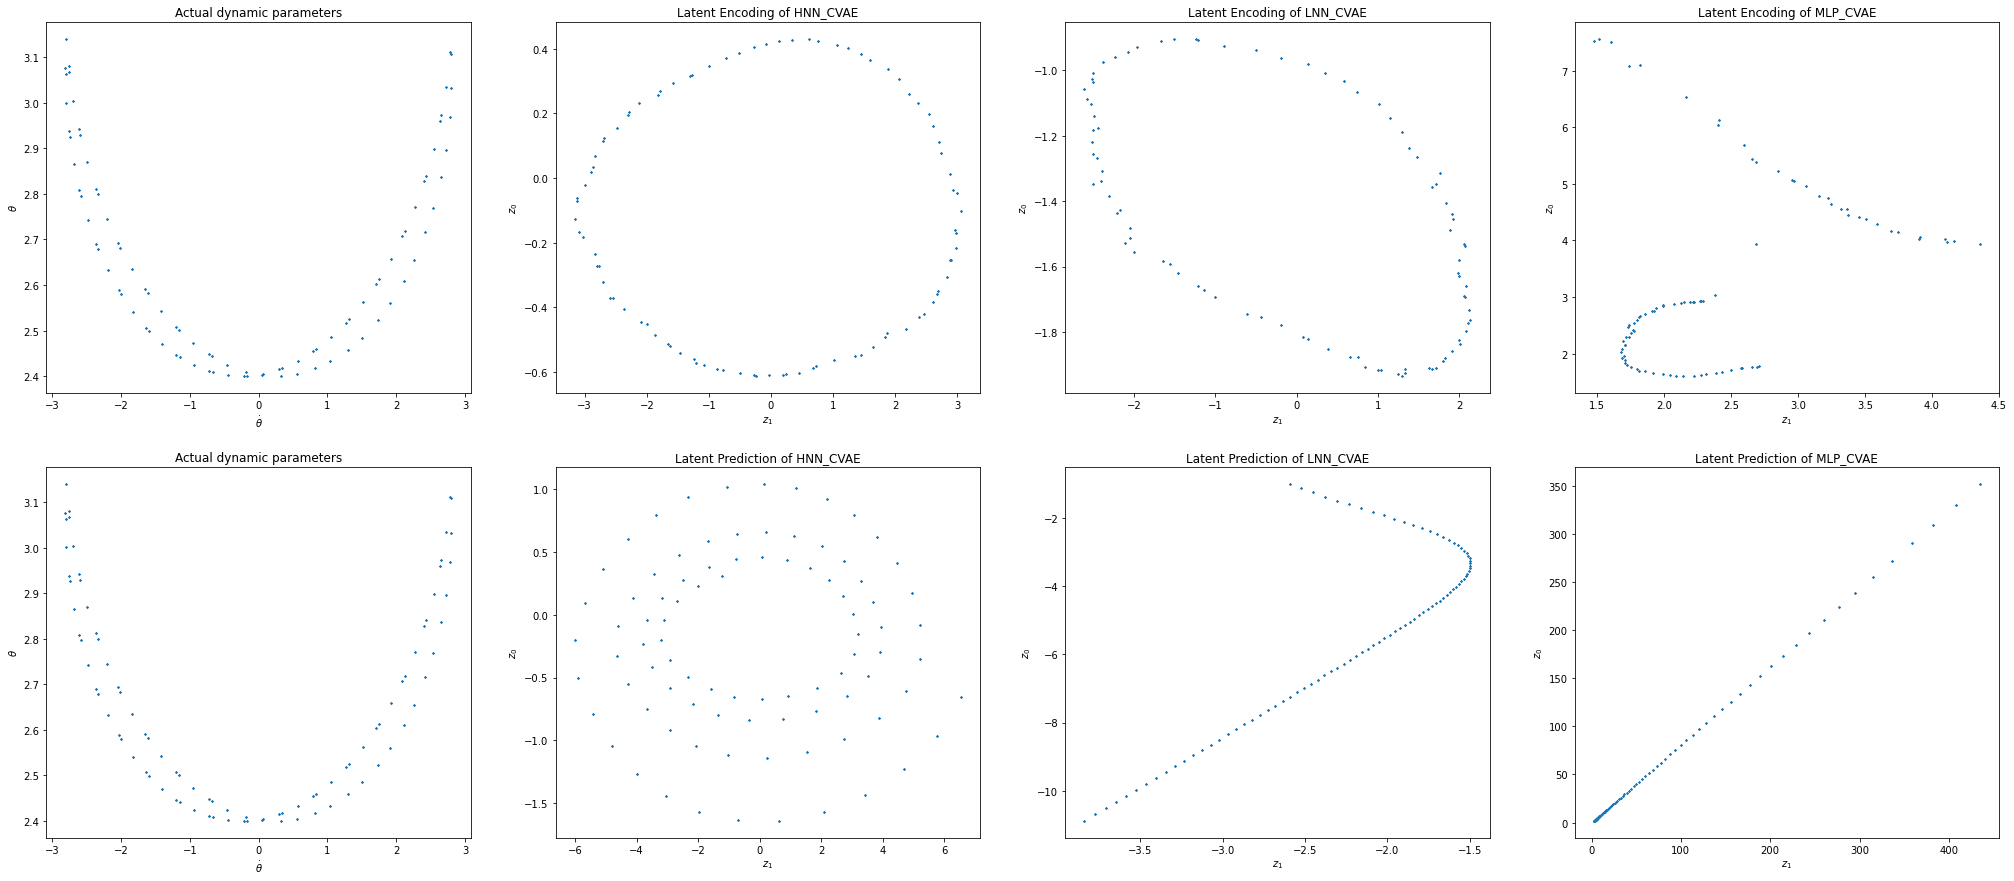

In [21]:
fig = plt.figure(figsize=(35,15))
ax = []
input_len = batch.shape[0]
idx = 1

# convert numpy to tensor
x = data['test_data'][0,:,:seq_len,...]
batch = torch.tensor(x)
b, s, h, w, c = batch.size()

# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'LNN' in model_names[0]:
    z_actual = data['train_meta_data']['gcoords_in'][0,:]
elif 'HNN' in model_names[0]:
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
else:
    # choose canonical or generalized coordinates for MLP network?
    z_actual = data['train_meta_data']['ccoords_in'][0,:]

# plot actual representation
ax.append(fig.add_subplot(2,len(models)+1,1))
plt.plot(z_actual[:,1], z_actual[:,0],'*', markersize=2)
ax[-1].set_title("Actual dynamic parameters")
plt.xlabel("$\dot \\theta$")
plt.ylabel("$\\theta$")
idx += 1


# plot output images
for i, model in enumerate(models):
    
    # get latent representation
    if model.ae_params['convolutional']:
        this_batch = batch.reshape(b, s * c, h, w)
    else:
        this_batch = batch.reshape(b, s * c * h * w)
        
    if model.ae_params['variational']:
        mu, log = model.ae.encode(this_batch)
        z_latent = model.ae.reparameterize(mu, log).detach().numpy()
    else:
        z_latent = model.ae.encode(this_batch).detach().numpy()
    
    # plot latent encoding
    ax.append(fig.add_subplot(2,len(models)+1,idx))
    plt.plot(z_latent[:,1], z_latent[:,0],'*', markersize=2)
    ax[-1].set_title(f"Latent Encoding of {model_names[i]}")
    plt.ylabel("$z_0$")
    plt.xlabel("$z_1$")
    idx += 1
        
    # plot latent prediction
    ax.append(fig.add_subplot(2,len(models)+1,idx+len(models)))
    plt.plot(pred_z1[i][:], pred_z0[i][:],'*', markersize=2)
    ax[-1].set_title(f"Latent Prediction of {model_names[i]}")
    plt.ylabel("$z_0$")
    plt.xlabel("$z_1$")
    
# plot actual representation
ax.append(fig.add_subplot(2,len(models)+1,len(models)+2))
plt.plot(z_actual[:,1], z_actual[:,0],'*', markersize=2)
ax[-1].set_title("Actual dynamic parameters")
plt.xlabel("$\dot \\theta$")
plt.ylabel("$\\theta$")
    
#ax[9].set_xlabel("Number of Input Sequence (time step)")
#ax[10].set_xlabel("Number of Input Sequence (time step)")
#ax[11].set_xlabel("Number of Input Sequence (time step)")

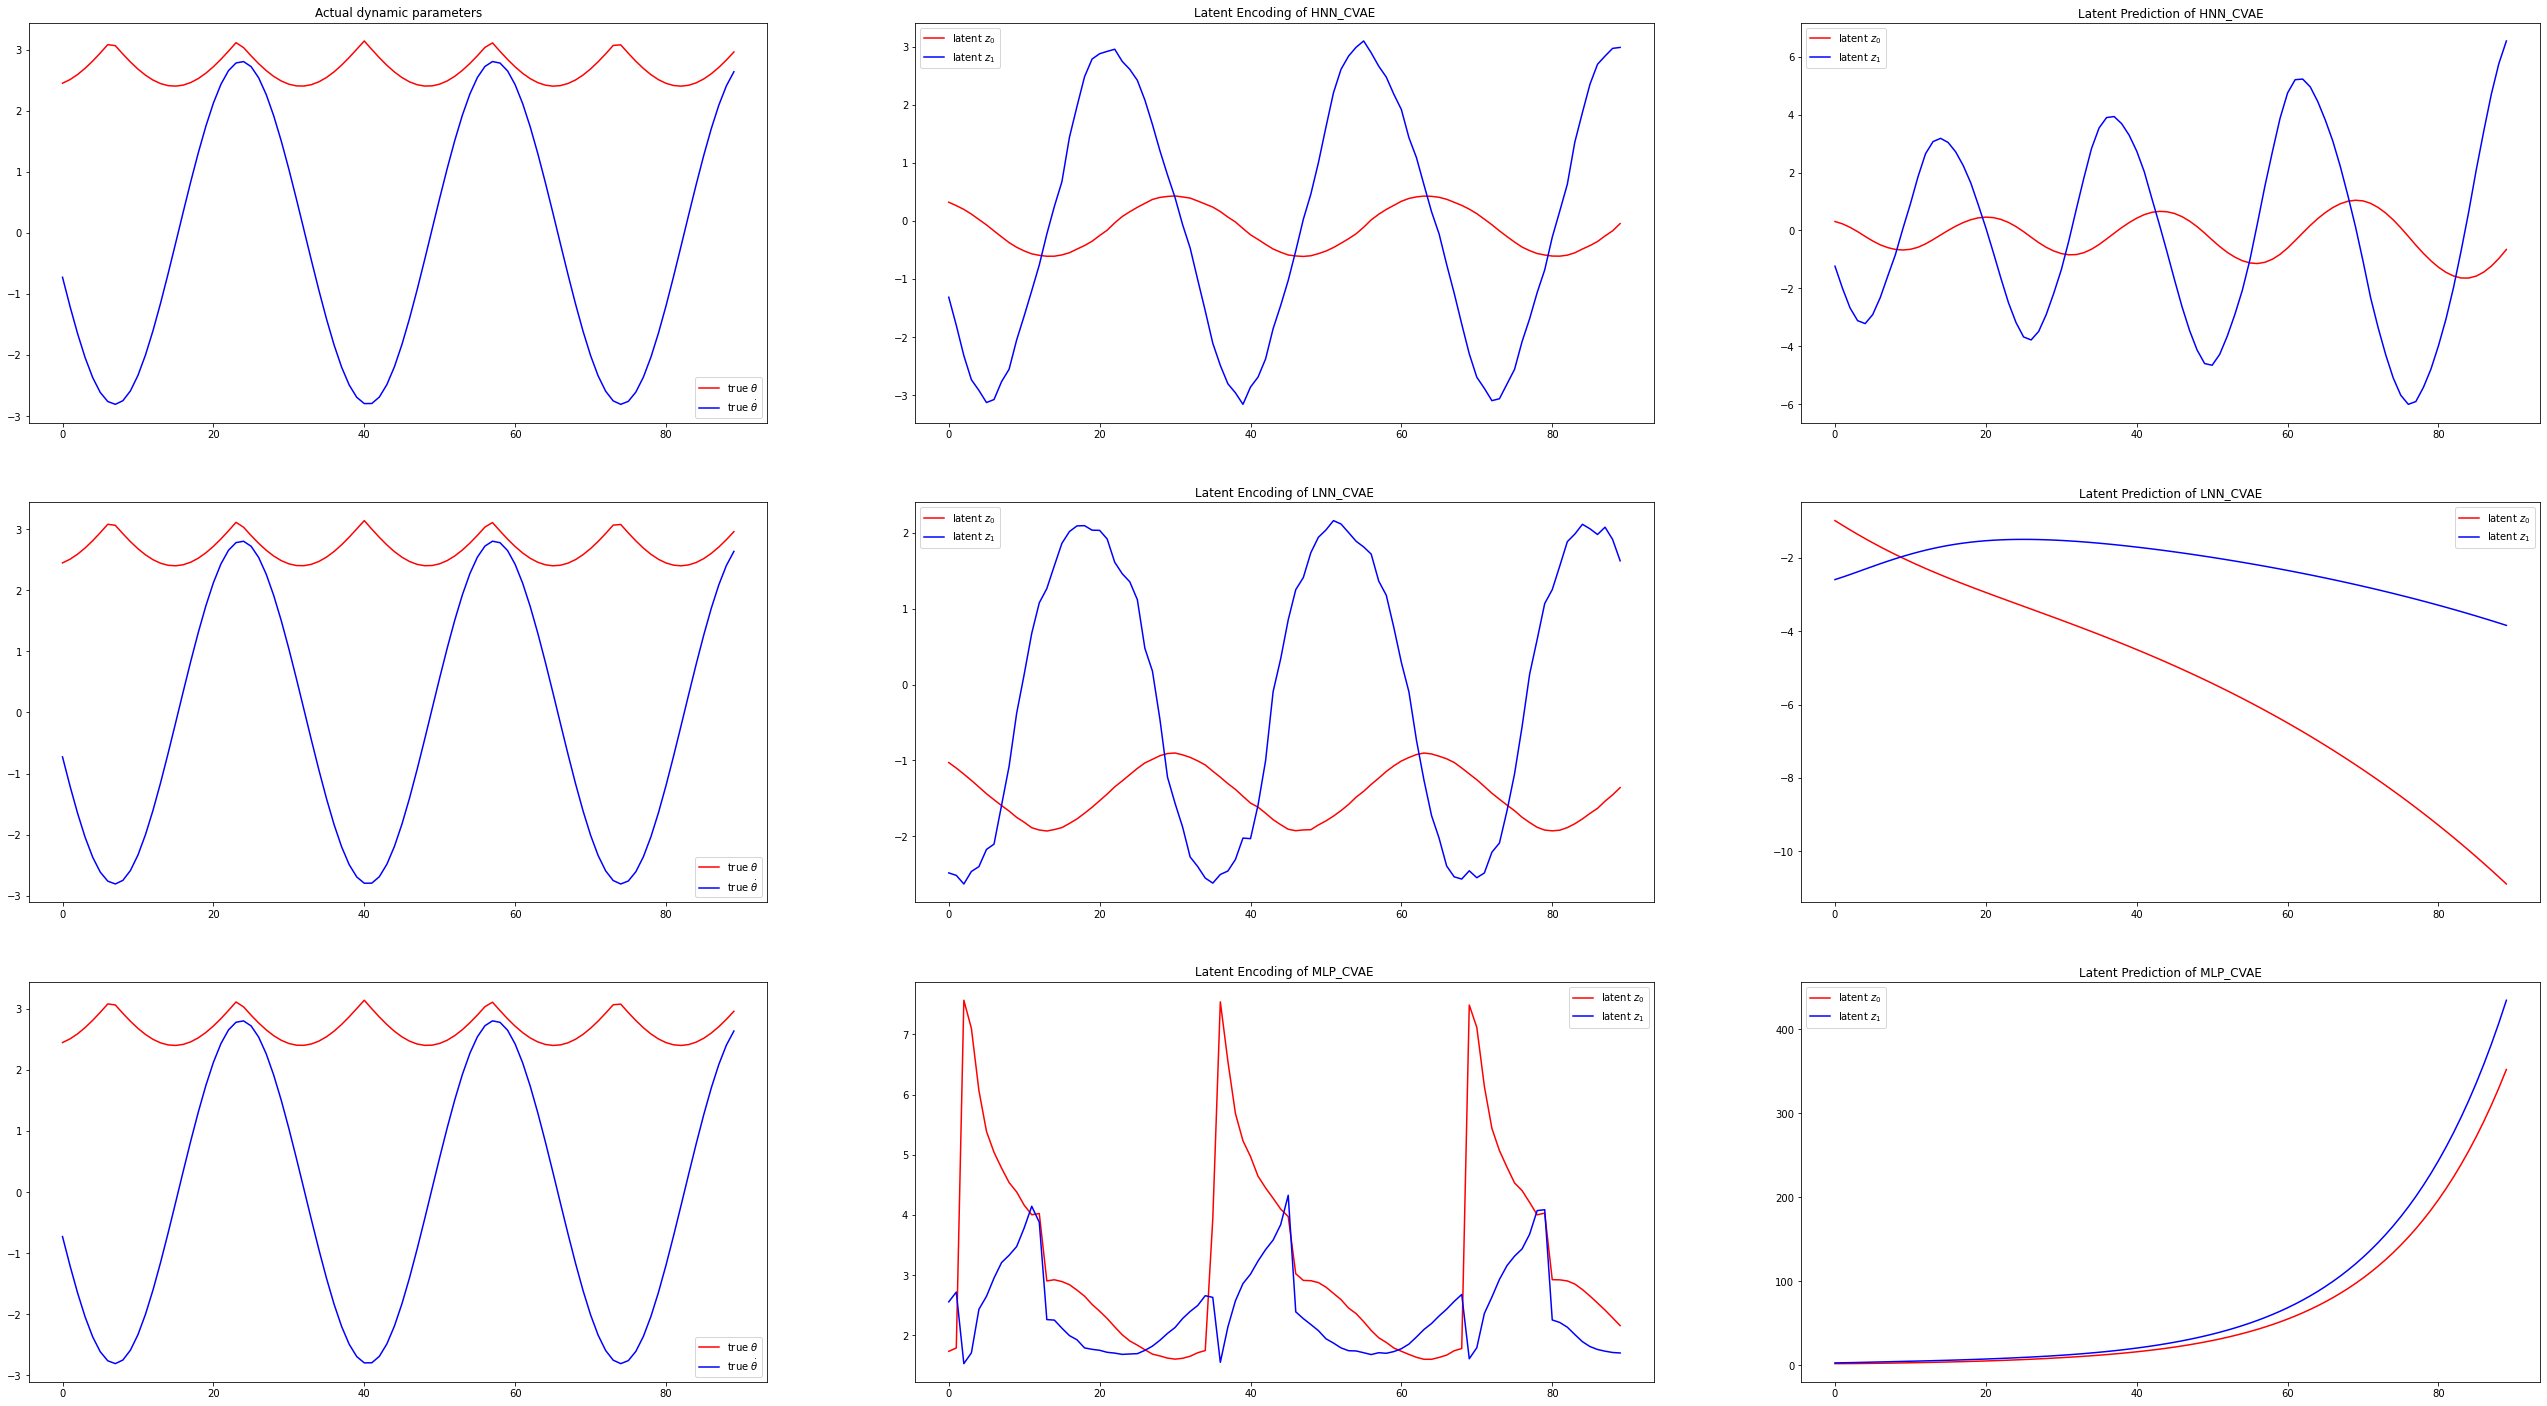

In [22]:
fig = plt.figure(figsize=(45,25))
ax = []
input_len = batch.shape[0]
idx = 1

# convert numpy to tensor
x = data['test_data'][0,:,:seq_len,...]
batch = torch.tensor(x)
b, s, h, w, c = batch.size()

# plot output images
for i, model in enumerate(models):    
    # get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
    if 'LNN' in model_names[i]:
        z_actual = data['train_meta_data']['gcoords_in'][0,:]
    elif 'HNN' in model_names[i]:
        z_actual = data['train_meta_data']['ccoords_in'][0,:]
    else:
        # choose canonical or generalized coordinates for MLP network?
        z_actual = data['train_meta_data']['ccoords_in'][0,:]
        
    # plot actual representation
    ax.append(fig.add_subplot(len(models),3,idx))
    plt.plot(z_actual[:,0], "r-", label='true $\\theta$')
    plt.plot(z_actual[:,1], "b-", label='true $\dot \\theta$')
    ax[0].set_title("Actual dynamic parameters")
    plt.legend()
    idx += 1
    
    # get latent representation
    if model.ae_params['convolutional']:
        this_batch = batch.reshape(b, s * c, h, w)
    else:
        this_batch = batch.reshape(b, s * c * h * w)
        
    if model.ae_params['variational']:
        mu, log = model.ae.encode(this_batch)
        z_latent = model.ae.reparameterize(mu, log).detach().numpy()
    else:
        z_latent = model.ae.encode(this_batch).detach().numpy()
    
    # plot latent encoding
    ax.append(fig.add_subplot(len(models),3,idx))
    plt.plot(z_latent[:,0], "r-", label='latent $z_0$') 
    plt.plot(z_latent[:,1], "b-", label='latent $z_1$')
    ax[-1].set_title(f"Latent Encoding of {model_names[i]}")
    plt.legend()
    idx += 1
        
    # plot latent prediction
    ax.append(fig.add_subplot(len(models),3,idx))
    plt.plot(pred_z0[i][:], "r-", label='latent $z_0$') 
    plt.plot(pred_z1[i][:], "b-", label='latent $z_1$')
    ax[-1].set_title(f"Latent Prediction of {model_names[i]}")
    plt.legend()
    idx += 1
    
#ax[15].set_xlabel("Number of Input Sequence (time step)")
#ax[16].set_xlabel("Number of Input Sequence (time step)")
#ax[17].set_xlabel("Number of Input Sequence (time step)")

## 5.3 Acceleration (only for Lagrangian Neural Network)

### Encoded Acceleration

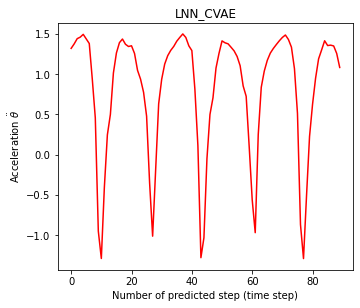

In [23]:
# convert numpy to tensor
x = data['test_data'][0,:,:seq_len,...]
batch = torch.tensor(x)
b, s, h, w, c = batch.size()


fig = plt.figure(figsize=(18,10))
ax = []
input_len = batch.shape[0]
idx = 1

# plot output images
for i, model in enumerate(models):
    if 'LNN' in model_names[i]:
        if model.ae_params['convolutional']:
            this_batch = batch.reshape(b, s * c, h, w)
        else:
            this_batch = batch.reshape(b, s * c * h * w)

        # get latent representation
        if model.ae_params['variational']:
            mu, log = model.ae.encode(this_batch)
            z_latent = model.ae.reparameterize(mu, log).detach().numpy()
        else:
            z_latent = model.ae.encode(this_batch).detach().numpy()

        # get latent acceleration
        q, qdot = model.ddn.to_config_space(z_latent)
        q = torch.tensor(q)
        qdot = torch.tensor(qdot)
        acc_enc = model.ddn(q, qdot)

        # plot latent acceleration
        ax.append(fig.add_subplot(2,len(models),idx))
        ax[-1].set_xlabel("Number of predicted step (time step)")
        ax[0].set_ylabel("Acceleration $\ddot \\theta$")
        plt.plot(acc_enc[:].detach().numpy(), "r-")
        ax[-1].set_title(f"{model_names[i]}")

        idx += 1

### Predicted Acceleration

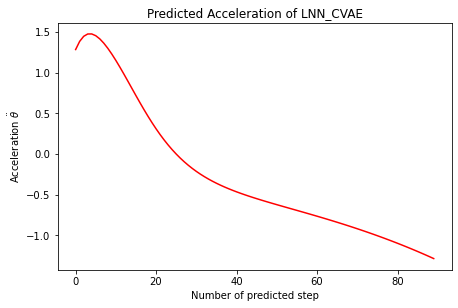

In [24]:
fig = plt.figure(figsize=(24,10))
ax = []
input_len = batch.shape[0]
idx = 1

# plot output images
for i, model in enumerate(models):
    if 'LNN' in model_names[i]:
        ax.append(fig.add_subplot(2,len(models),idx))
        ax[-1].set_xlabel("Number of predicted step")
        ax[-1].set_ylabel("Acceleration $\ddot \\theta$")
        plt.plot(pred_z2[i][:], "r-") 
        ax[-1].set_title(f"Predicted Acceleration of {model_names[i]}")

        idx += 1

# 6. Hamiltonian / Lagrangian

In this section we will look at the encoded Hamiltonian (total energy) and Lagrangian of the model. 

## 6.1 Encoded Hamiltonian / Lagrangian

First we will take a look at the encoded value. Since the Hamiltonian represents the total energy (kinetic + potential energy) it should stay at the same level. The Lagrangian represents the difference between kinetic and potential energy, which is why it should oscillate.

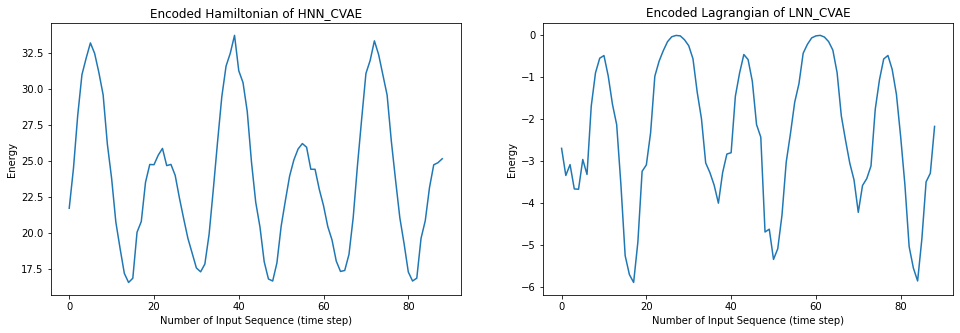

In [25]:
# plot encoded energy
x = data['test_data'][0,:89,:seq_len,...]
this_batch = torch.tensor(x)
this_batch = this_batch.permute(0, 1, 4, 2, 3)

fig = plt.figure(figsize=(25,5))
ax = []
idx = 1

no_pred = [None] * len(models)

for i, model in enumerate(models):
    if "MLP" in model_names[i]:
        continue
    no_pred[i] = model(this_batch, 0, model.ae_params['variational'], model.ae_params['convolutional'])
    enc_energies = np.array(no_pred[i].energies)[-1,:,-1]
    ax.append(fig.add_subplot(1,len(models),idx))
    ax[-1].set_xlabel("Number of Input Sequence (time step)")
    ax[-1].set_ylabel("Energy")
    plt.plot(enc_energies)
    if 'LNN' in model_names[i]:
        ax[-1].set_title(f"Encoded Lagrangian of {model_names[i]}")
    elif 'HNN' in model_names[i]:
        ax[-1].set_title(f"Encoded Hamiltonian of {model_names[i]}")
    else:
        ax[-1].set_title(f"Encoded Energy of {model_names[i]}")

    idx += 1

## 6.2 Predicted Hamiltonian / Lagrangian

Now we will take a look at the predicted value. 

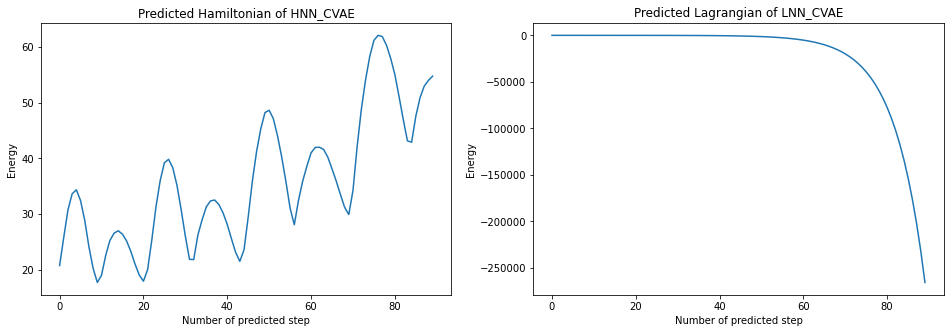

In [26]:
fig = plt.figure(figsize=(25,5))
ax = []
input_len = batch.shape[0]
idx = 1

# plot output images
for i, model in enumerate(models):
    if "MLP" in model_names[i]:
        continue
    ax.append(fig.add_subplot(1,len(models),idx))
    ax[-1].set_xlabel("Number of predicted step")
    ax[-1].set_ylabel("Energy")
    plt.plot(pred_energies[i])
    if 'LNN' in model_names[i]:
        ax[-1].set_title(f"Predicted Lagrangian of {model_names[i]}")
    elif 'HNN' in model_names[i]:
        ax[-1].set_title(f"Predicted Hamiltonian of {model_names[i]}")
    else:
        ax[-1].set_title(f"Predicted Energy of {model_names[i]}")

    idx += 1

## 6.3 Encoded vs Predicted Hamiltonian / Lagrangian

<ipython-input-27-b8e60198a661>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.append(fig.add_subplot(len(models),2,idx))
<ipython-input-27-b8e60198a661>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.append(fig.add_subplot(len(models),2,idx))


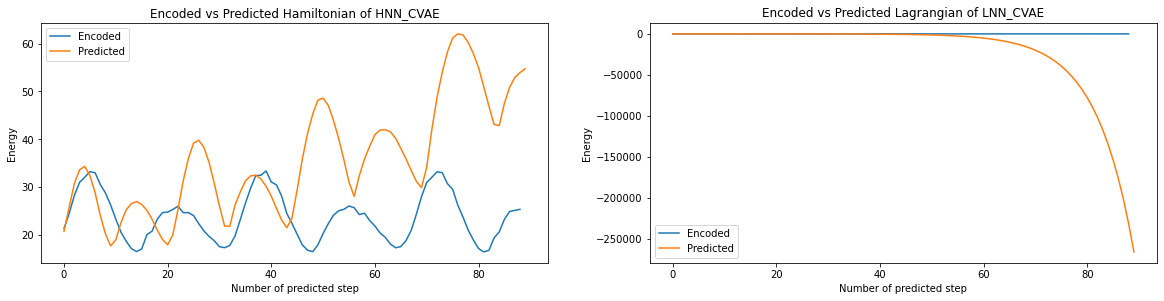

In [27]:
fig = plt.figure(figsize=(20,15))
ax = []
input_len = batch.shape[0]
idx = 1

x = data['test_data'][0,:89,:seq_len,...]
this_batch = torch.tensor(x)
this_batch = this_batch.permute(0, 1, 4, 2, 3)

no_pred = [None] * len(models)

# plot output images
for i, model in enumerate(models):
    if "MLP" in model_names[i]:
        continue
    # encoded
    no_pred[i] = model(this_batch, 0, model.ae_params['variational'], model.ae_params['convolutional'])
    enc_energies = np.array(no_pred[i].energies)[-1,:,-1]
    ax.append(fig.add_subplot(len(models),2,idx))
    plt.plot(enc_energies, label='Encoded')
        
    #idx += 1
    
    # predicted
    ax.append(fig.add_subplot(len(models),2,idx))
    ax[-1].set_xlabel("Number of predicted step")
    ax[-1].set_ylabel("Energy")
    plt.plot(pred_energies[i], label='Predicted')
    if 'LNN' in model_names[i]:
        ax[-1].set_title(f"Encoded vs Predicted Lagrangian of {model_names[i]}")
    elif 'HNN' in model_names[i]:
        ax[-1].set_title(f"Encoded vs Predicted Hamiltonian of {model_names[i]}")
    else:
        ax[-1].set_title(f"Encoded vs Predicted Energy of {model_names[i]}")
        
    plt.legend()

    idx += 1

# 7. Image Prediction

Finally we will take a look at the predictive capabilities of the model

## 7.1 Prediction for small horizon

Row 1: Target Images
Row 2: HNN_CVAE
Row 3: LNN_CVAE
Row 4: MLP_CVAE


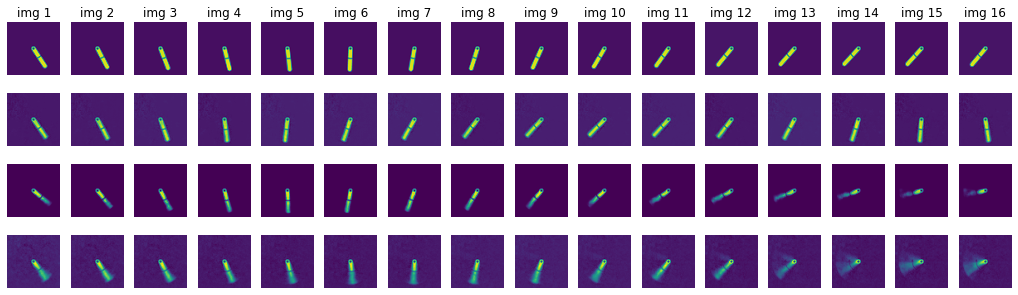

In [28]:
# specify start and length of interval to predict
ival_start = 0
ival_len = 16

fig = plt.figure(figsize=(18,5))
ax = []
idx = 1
    
# plot target images
for i in range(ival_start, ival_start+ival_len, 1):
    ax.append(fig.add_subplot(len(models)+1,ival_len,idx))
    ax[-1].set_title(f"img {i+1}")
    img = testset[i,2,-1,...].numpy().reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1
    
print(f"Row 1: Target Images")

# plot output images
for i, model in enumerate(models):    
    for j in range(ival_start, ival_start+ival_len, 1):
        ax.append(fig.add_subplot(len(models)+1,ival_len,idx))
        img = pred_img[i][0,j,...].reshape(-1, im_size)
        plt.axis('off')
        plt.imshow(img)
        idx += 1
        
    print(f"Row {i+2}: {model_names[i]}")

## 7.2 Prediction for larger horizon

Row 1: Target Images
Row 2: HNN_CVAE
Row 3: LNN_CVAE
Row 4: MLP_CVAE


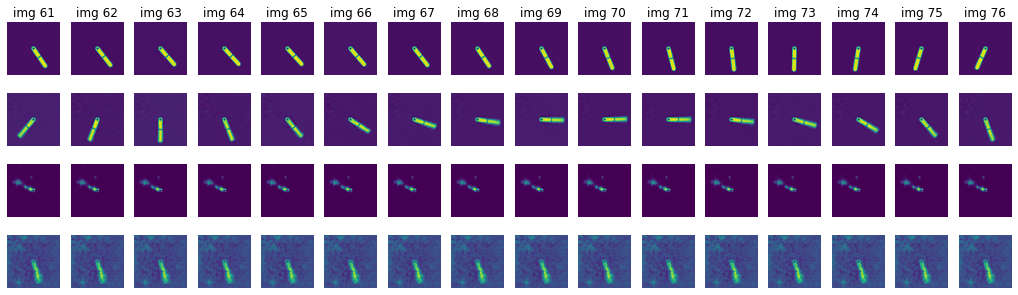

In [29]:
# specify start and length of interval to predict
ival_start = 60
ival_len = 16

fig = plt.figure(figsize=(18,5))
ax = []
idx = 1
    
# plot target images
for i in range(ival_start, ival_start+ival_len, 1):
    ax.append(fig.add_subplot(len(models)+1,ival_len,idx))
    ax[-1].set_title(f"img {i+1}")
    img = testset[i,2,-1,...].numpy().reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1
    
print(f"Row 1: Target Images")

# plot output images
for i, model in enumerate(models):    
    for j in range(ival_start, ival_start+ival_len, 1):
        ax.append(fig.add_subplot(len(models)+1,ival_len,idx))
        img = pred_img[i][0,j,...].reshape(-1, im_size)
        plt.axis('off')
        plt.imshow(img)
        idx += 1
        
    print(f"Row {i+2}: {model_names[i]}")

## 7.3 Video Prediction

Predicted Video of model HNN_CVAE


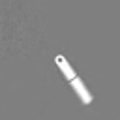

In [30]:
model_idx = 0

# predict input images for some timesteps and compare to actual ones
frames = pred_img[model_idx][0,:,-1,...]

# creates and saves gif
path = "./figures"
filename = "predicted_video"
gifname = figures.make_gif(frames, path, filename, duration=1e-1, pixels=[120, 120])

print(f"Predicted Video of model {model_names[model_idx]}")
Image(filename=gifname, width=200)


Actual Video


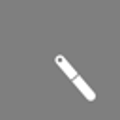

In [31]:
# takes frames of first episode
frames = data['test_data'][0,:,0,:,:,0]

# creates and saves gif
path = "./figures"
filename = "original_video"
gifname = figures.make_gif(frames, path, filename, duration=1e-1, pixels=[120, 120])

print("\nActual Video")
Image(filename=gifname, width=200)

In [32]:
train_params = pickle_load("/Users/jantiegges/Google Drive/Bachelorarbeit/BA/saved_models/HNN_CVAE/train_config")
print(train_params)

{'activation': 'relu', 'epochs': 3, 'batch_size': 16, 'loss_type': 'geco_mean', 'beta': 2, 'tol': 0.01, 'lambd': 1.0, 'alpha': 0.99, 'ae_lr': 0.00015, 'ddn_lr': 0.00015, 'pred_steps': 7}
